### Лабораторная работа 3

Работать следует с файлом 190422.WAV.

**1. Отобразите выровненное по синхроимпульсу изображение снимка**

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: WavFileWarning: Reached EOF prematurely; finished at 9240620 bytes, expected 9240625 bytes from header.
  if sys.path[0] == '':


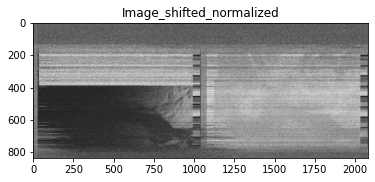

In [2]:
# Ваш код

from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import hilbert, chirp
import numpy as np
import scipy.signal

mpl.rcParams['agg.path.chunksize'] = 10000

input = read("190422.wav")
audio = input[1]

audio = np.array(audio, dtype=float)
n_data = (audio - 128) / 128

analytic_signal = hilbert(n_data)
amplitude_envelope = np.abs(analytic_signal)

resampled = scipy.signal.resample(amplitude_envelope, int(len(amplitude_envelope)/(5512/2080)))

resampled = resampled[0:len(resampled) - int(len(resampled)%2080)]

new_data = np.reshape(resampled, (int(len(resampled)/2080), 2080))

sinch = new_data[430][360+1040:390+1040]

zros = np.zeros(((int(len(resampled)/2080), 0)))
new_data_buffered = np.hstack((new_data, zros))

deltas = []

for i in range(np.shape(new_data_buffered)[0]):
    deltas.clear()
    for j in range(1250, 1600):
        delta = (new_data_buffered[i][j:j+len(sinch)] - sinch)**2
        deltas.append(np.sum(delta))
        minimal = deltas.index(min(deltas))
    new_data_buffered[i] = np.roll(new_data_buffered[i], -(1250+minimal))

telemetry_array = new_data_buffered[600:800, 1000:1010]

min = np.min(telemetry_array)
max = np.max(telemetry_array)

convert = np.polyfit([min, max], [0, 1], 1)

for i in range(np.shape(new_data_buffered)[0]):
    for j in range(np.shape(new_data_buffered)[1]):
        new_data_buffered[i][j] = np.polyval(convert, new_data_buffered[i][j])

        if new_data_buffered[i][j] >= 1:
            new_data_buffered[i][j] = 1

        if new_data_buffered[i][j] <= 0:
            new_data_buffered[i][j] = 0

new_data_buffered *= 255

plt.figure()
# Последний элемент убираем, потому что он (может быть) заполнен не полностью
plt.imshow(new_data_buffered[:-1], cmap='gray')
plt.title('Image_shifted_normalized')
plt.savefig("image_shifted_normalized.png")

**2. Выполните окрашивание левого канала изображения с использованием любой из палитр, представленных по ссылке: https://github.com/Xerbo/aptdec/tree/master/palettes. Отобразите результат**<br>
**_Может пригодиться функция `cv2.cvtColor()` ([описание из документации](https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html))_**

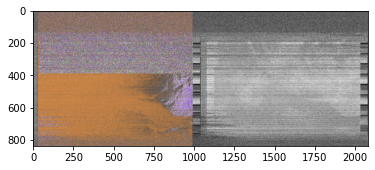

In [13]:
# Ваш код

img = plt.imread('palette_2.png')

data = np.zeros([np.shape(new_data_buffered)[0], np.shape(new_data_buffered)[1], 3])

for i in range(np.shape(new_data_buffered)[0]):
    for j in range(np.shape(new_data_buffered)[1]):
        tmp = np.array([int(new_data_buffered[i][j]), int(new_data_buffered[i][j]), int(new_data_buffered[i][j])])
        data[i][j] = tmp/255


for i in range(np.shape(new_data_buffered)[0]):
    for j in range(len(sinch), 990):
        x = new_data_buffered[i][j]
        y = new_data_buffered[i][j+1040]
        data[i][j] = np.array(img[int(x)][int(y)])

plt.imshow(data)
plt.savefig("image_coloured.png")

**3. Запишите в переменные `start_latlon` и `end_latlon` проекции положений спутника NOAA-19 в моменты начала приема сигнала и конца в радианах, если локальные дата и время начала приема сигнала - 18 апреля 2022 года 18:30:N (МСК), где N - ваш номер по порядку в списке группы** 

In [14]:
# Ваш код

from cmath import pi
from datetime import datetime, date, timedelta
from skyfield.api import load, wgs84
from skyfield.api import EarthSatellite
from mpl_toolkits.mplot3d import axes3d

tle_1 = '1 33591U 09005A   22069.18326583  .00000083  00000-0  69793-4 0  9999'
tle_2 = '2 33591  99.1613 101.1760 0014836 106.3564 253.9239 14.12536020674436'

satellite = EarthSatellite(tle_1, tle_2, "NOAA 19")

ts = load.timescale()
t_start = ts.utc(2022, 4, 18, 18, 30, 9.5)
t_end = t_start + timedelta(seconds = np.shape(new_data_buffered)[0]/2 + 0.5)

g1 = satellite.at(t_start)
g2 = satellite.at(t_end)

start_lat_rad, start_lon_rad = wgs84.latlon_of(g1)
end_lat_rad, end_lon_rad = wgs84.latlon_of(g2)

start_latlon = start_lat_rad.radians, start_lon_rad.radians # start_latlon = start_lat_rad, start_lon_rad
end_latlon = end_lat_rad.radians, end_lon_rad.radians   # end_latlon = end_lat_rad, end_lon_rad

In [15]:
%pip install pyshp

Note: you may need to restart the kernel to use updated packages.


In [16]:
from scipy import interpolate
import shapefile


def draw(img):
    yaw = 0.
    vscale = 1
    hscale = 1

    # Compute the great-circle distance between two points
    # The units of all input and output parameters are radians
    def distance(lat1, lon1, lat2, lon2):
        # https://en.wikipedia.org/w/index.php?title=Great-circle_distance&oldid=749078136#Computational_formulas

        delta_lon = lon2 - lon1

        cos_central_angle = np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(delta_lon)
        
        if cos_central_angle < -1:
            cos_central_angle = -1
        
        if cos_central_angle > 1:
            cos_central_angle = 1

        return np.arccos(cos_central_angle)

    height = len(img)

    y_res = distance(*start_latlon, *end_latlon) / height / vscale
    x_res = 0.0005 / hscale

    # Compute azimuth of line between two points
    # The angle between the line segment defined by the points (`lat1`,`lon1`) and (`lat2`,`lon2`) and the North
    # The units of all input and output parameters are radians
    def azimuth(lat1, lon1, lat2, lon2):
        # https://en.wikipedia.org/w/index.php?title=Azimuth&oldid=750059816#Calculating_azimuth

        delta_lon = lon2 - lon1

        return np.arctan2(np.sin(delta_lon), np.cos(lat1) * np.tan(lat2) - np.sin(lat1) * np.cos(delta_lon))

    ref_az = azimuth(*start_latlon, *end_latlon)

    def latlon_to_rel_px(latlon):
        az = azimuth(*start_latlon, *latlon)
        B = az - ref_az

        c = distance(*latlon, *start_latlon)

        if c < -np.pi / 3:
            c = -np.pi / 3
        
        if c > np.pi / 3:
            c = np.pi / 3

        a = np.arctan(np.cos(B) * np.tan(c))
        b = np.arcsin(np.sin(B) * np.sin(c))

        x = -b / x_res

        # Add the yaw correction value
        # Should be calculating sin(yaw) * x but yaw is always a small value
        y = a / y_res + yaw * x

        return (x, y)

    def draw_line(latlon1, latlon2, r, g, b, a):
        # Convert latlon to (x, y)
        (x1, y1) = latlon_to_rel_px(latlon1)
        (x2, y2) = latlon_to_rel_px(latlon2)

        f = interpolate.interp1d((x1, x2), (y1, y2))
        xar = np.arange(x1, x2)
        dlimg = len(img[0]) / 2080
        bounds_1 = int(dlimg * 456) # 456
        bounds_2 = int(dlimg * 600) # 600
        shift_1 = int(dlimg * 539) # 539
        shift_2 = int(dlimg * 1579) # 1579
        if (x1 > -bounds_1 and x1 < bounds_1 and y1 > 0. and y1 < height) or (x1 > -bounds_2 and x1 < bounds_2 and y1 > 0. and y1 < height):
            for x in xar:
                y = f(x)
                if x > -bounds_1 and x < bounds_1 and y > 0 and y < height:
                    img[int(y), int(x) + shift_1] = [r, g, b]
                    img[int(y), int(x) + shift_2] = [r, g, b]

    def draw_shape(shpfile, r, g, b):
        reader = shapefile.Reader(shpfile)
        for shape in reader.shapes():
            prev_pt = shape.points[0]
            for pt in shape.points:
                draw_line(
                    (pt[1] / 180. * np.pi, pt[0] / 180. * np.pi),
                    (prev_pt[1] / 180. * np.pi, prev_pt[0] / 180. * np.pi),
                    r, g, b, 0
                );
                prev_pt = pt;

    draw_shape("https://github.com/nvkelso/natural-earth-vector/blob/master/10m_cultural/ne_10m_admin_0_countries.shp?raw=true", 255, 255, 0)
    return img

**4. Выполните функцию `draw()`, передав в нее в качестве аргумента копию вашего окрашенного изображения. Результат выполнения (новое изображение) отобразите**

Функция `draw()` нанесет на левый канал вашего изображения контуры стран в соотвествии с вычисленными вами в п.3 `start_latlon` и `end_latlon`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


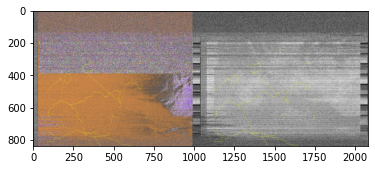

In [17]:
# Ваш код
plt.imshow(draw(data))

**5. Сохраните окрашенное изображение с нанесенными на него контурами стран в файл. Обратите внимание, что не следует сохранять излишние данные - синхроимпульсы, минутные метки, телеметрию и данные второго канала**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


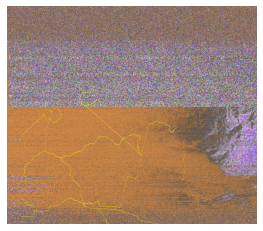

In [22]:
# Ваш код
data_cut = data[:, len(sinch):990]
plt.imshow(data_cut)
plt.axis('off')
plt.savefig("image_cut.png")

**6. Вычислите и выведите две опорные точки в формате:**

`ImgX_1    ImgY_1    MapX_1    MapY_1`<br>
`ImgX_2    ImgY_2    MapX_2    MapY_2`


`ImgX_1, ImgY_1` - координаты центра первой принятой линии в пикселях;<br>
`ImgX_2, ImgY_2` - координаты центра последней принятой линии в пикселях;<br>
`MapX_1, MapY_1` - координаты карты, соответствующие `ImgX_1, ImgY_1` в метрах;<br>
`MapX_2, MapY_2` - аналогично.<br>
Напоминаю, что начало координат "пискельной" системы координат изображения находится в левом верхнем углу, ось Х направлена вправо, Y - вверх.<br>
Также напоминаю, что для рендеринга карт в Google Maps, OpenStreetMap и т.д. используется проецируемая система координат [WGS 84 / Pseudo-Mercator -- Spherical Mercator](https://epsg.io/3857).<br>
Для вычисления координат карты в метрах рекомендую использовать метод `from_crs()` класса `Transformer` модуля `pyproj`.

Результат сохраните в текстовый файл для дальнейшего использования в ArcGIS.

In [21]:
# Ваш код
import pyproj

ImgX_1 = np.shape(data_cut)[0]/2
ImgY_1 = 0

ImgX_2 = np.shape(data_cut)[0]/2
ImgY_2 = -np.shape(data_cut)[1]

transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:3857")
MapX_1, MapY_1 = transformer.transform(start_latlon[0], start_latlon[1])
MapX_2, MapY_2 = transformer.transform(end_latlon[0], end_latlon[1])

print(ImgX_1, ImgY_1, MapX_1, MapY_1, sep= " ")
print(ImgX_2, ImgY_2, MapX_2, MapY_2, sep= " ")

419.0 0 49259.421163010455 -80308.75134857102
419.0 -960 35554.21008037766 -32962.95104606777


**Дальнейшая работа выполняется в ArcGIS**

**7. Осуществите географическую привязку изображения, полученного в результате выполнения п.5, с использованием текстового файла из п.6**

**8. Дополните опорные точки вручную**

**9. Сохраните в папку на вашем google диске ноутбук, текстовый файл и скриншот работы, выполненной в ArcGIS. На скриншоте должны быть видны привязанное изображение, а также таблица опорных точек**